<a href="https://colab.research.google.com/github/arinaaandreeva/ML_lab_1/blob/main/ML_Lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install shap
!pip install interpret

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 34.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.7 MB/s eta 0:00:00
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 87.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 37.3 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler


from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.ensemble import RandomForestClassifier

import shap
from sklearn.linear_model import LinearRegression
import interpret.glassbox

## **Base EDA and data preprocessing: (+3)**



**a. clarify the meaning of features you are going to exploit**

* Grade -таргет, бинарная зависимая переменная.(0 = "LGG"; 1 = "GBM")
* Были удалены ненужные признаки ID, primary_diagnosis
* Возраст был преобразован в числовой формат
* были обнаружены пропуски в  виде "--", "not reported". Для числовых признаков они были заполнены модой.
* Race, IDH1, TP53, ATRX, PTEN, EGFR, CIC, MUC16, PIK3CA,
NF1, PIK3R1, FUBP1, RB1, NOTCH1, BCOR, CSMD3, SMARCA4,
GRIN2A, IDH2, FAT4, PDGFRA категориальные признаки, которые были закодированы
*

### Предобработка данных

In [7]:
train = pd.read_csv('https://raw.githubusercontent.com/arinaaandreeva/ML_lab_1/refs/heads/main/data/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/arinaaandreeva/ML_lab_1/refs/heads/main/data/test.csv')


#ID не нужен, не несет смысловой нагрузки для регрессии
train.drop(['Case_ID', 'Unnamed: 0', 'Primary_Diagnosis'], axis=1, inplace=True)
test.drop(['Case_ID', 'Unnamed: 0', 'Primary_Diagnosis'], axis=1, inplace=True)

# Возраст был записан текстом с месяцами, переведем в целое число лет
train['Age_at_diagnosis'] = train.Age_at_diagnosis.str.split(' ').apply(lambda x: x[0] if x else None)
test['Age_at_diagnosis'] = test.Age_at_diagnosis.str.split(' ').apply(lambda x: x[0] if x else None)

#В данных вместо пропусков --, поэтому заменяем на nan
print(train.Gender.unique())

# В тренировочной и тестовой выборках есть несколько пропусков.Заполняем их часто самым встречающимся значением из тестовой выборки
train = train.replace('--', np.nan).replace('not reported', np.nan)
test = test.replace('--', np.nan).replace('not reported', np.nan)


train.fillna(train.mode().iloc[0], inplace=True)
test.fillna(train.mode().iloc[0], inplace=True)

['Male' 'Female' '--']


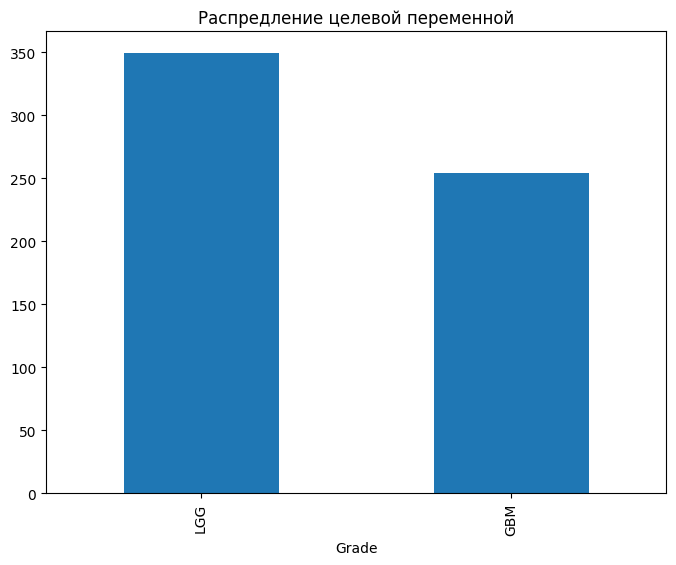

In [8]:
#Отсутствует дисбаланс классов
plt.figure(figsize=(8, 6))
train['Grade'].value_counts().plot(kind='bar')
plt.title('Распредление целевой переменной')
plt.xlabel('Grade')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

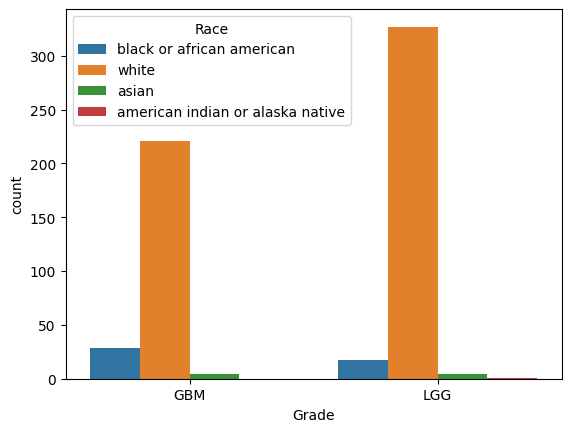

In [9]:
#нет ни одного american indian or alaska native, который бы GBM
sns.countplot(data=train, x='Grade', hue='Race');

**b. Execute the correlation analysis of variables, try to establish dependent one**

**d. Perform data preprocessing (encode your features in some way, different types of encoding may dramatically affect your model, be selective, try multiple (at leas 2) ways)**

Пробуем два энкодера:

* One-hot создает бинарные переменные
* Label использует также порядковые значения

Данные методы отличаются только для столбца Race. Содержательно мы не можем ранжировать расы, поэтому будем использовать onehot-encoder. Также по матрице корреляции ниже видно, что признаки закодированные через onehot encoder более коррелируют с таргетом.


#### One-hot encoding


In [10]:
train['Grade'] = np.where(train['Grade'] == 'GBM', 1, 0) #Кодируем таргет

encoder = OneHotEncoder(drop='first')
# Список категор переменных
categ_col = ['Gender','Race','IDH1', 'TP53', 'ATRX', 'PTEN', 'EGFR', 'CIC', 'MUC16', 'PIK3CA', 'NF1',
       'PIK3R1', 'FUBP1', 'RB1', 'NOTCH1', 'BCOR', 'CSMD3', 'SMARCA4',
       'GRIN2A', 'IDH2', 'FAT4', 'PDGFRA']

#Тренироввочная выборка
encoded_features = encoder.fit_transform(train[categ_col]).toarray()
encoded_feature_names = encoder.get_feature_names_out(categ_col)
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)
train_ohe = pd.concat([train, encoded_df], axis=1).drop(categ_col, axis=1)

#тестовая выборка
encoded_df_test = encoder.transform(test[categ_col]).toarray()
encoded_df_test = pd.DataFrame(encoded_df_test, columns=encoded_feature_names)
test_ohe = pd.concat([test, encoded_df_test], axis=1).drop(categ_col, axis=1)
train_ohe

,Grade,Age_at_diagnosis,Gender_Male,Race_asian,Race_black or african american,Race_white,IDH1_NOT_MUTATED,TP53_NOT_MUTATED,ATRX_NOT_MUTATED,PTEN_NOT_MUTATED,...,FUBP1_NOT_MUTATED,RB1_NOT_MUTATED,NOTCH1_NOT_MUTATED,BCOR_NOT_MUTATED,CSMD3_NOT_MUTATED,SMARCA4_NOT_MUTATED,GRIN2A_NOT_MUTATED,IDH2_NOT_MUTATED,FAT4_NOT_MUTATED,PDGFRA_NOT_MUTATED
0,1,79,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0,53,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
2,0,61,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0,58,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0,30,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,1,67,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
599,0,27,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
600,0,29,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
601,0,51,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [11]:
# scaler = MinMaxScaler()

# Xtrain_scaled = scaler.fit_transform(train_ohe.drop('Grade', axis=1))
# train_ohe = pd.DataFrame(Xtrain_scaled, columns=train_ohe.drop('Grade', axis=1).columns)
# train_ohe['Grade'] = train['Grade']

# Xtest_scaled = scaler.transform(test_ohe)
# test_ohe = pd.DataFrame(Xtest_scaled, columns=test_ohe.columns)

#### Label encoding

In [12]:
categ_col = ['Gender','Race','IDH1', 'TP53', 'ATRX', 'PTEN', 'EGFR', 'CIC', 'MUC16', 'PIK3CA', 'NF1',
       'PIK3R1', 'FUBP1', 'RB1', 'NOTCH1', 'BCOR', 'CSMD3', 'SMARCA4',
       'GRIN2A', 'IDH2', 'FAT4', 'PDGFRA']


label_encoders = {}
label_train = pd.DataFrame(train['Grade'])
label_test = pd.DataFrame()

for col in categ_col:
    le = LabelEncoder()
    label_train[col] = le.fit_transform(train[col])
    label_encoders[col] = le



for col in categ_col:
    label_test[col] = label_encoders[col].transform(test[col])

In [13]:
# scaler = MinMaxScaler()

# Xtrain_scaled = scaler.fit_transform(label_train.drop('Grade', axis=1))
# label_train = pd.DataFrame(Xtrain_scaled, columns=label_train.drop('Grade', axis=1).columns)
# label_train['Grade'] = train['Grade']

# Xtest_scaled = scaler.transform(label_test)
# label_test = pd.DataFrame(Xtest_scaled, columns=label_test.columns)

#### Correlation


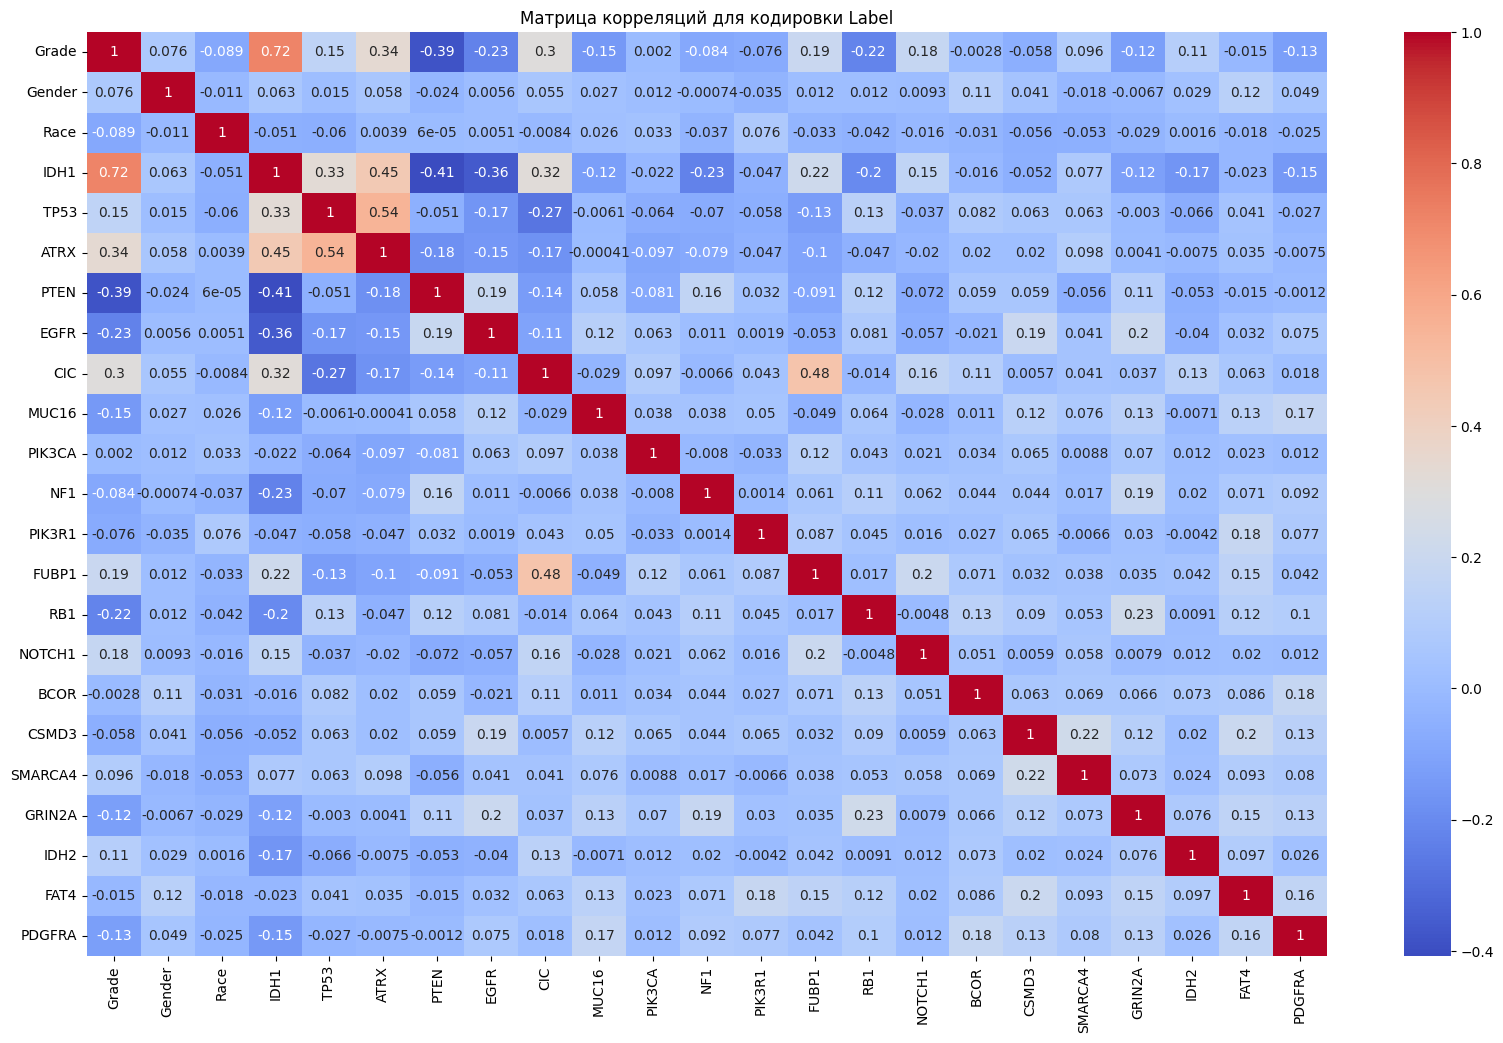

In [14]:
corr_matrix1 = label_train.corr()

plt.figure(figsize=(20, 12))
sns.heatmap(corr_matrix1, annot=True, cmap='coolwarm')
plt.title('Матрица корреляций для кодировки Label')
plt.show()

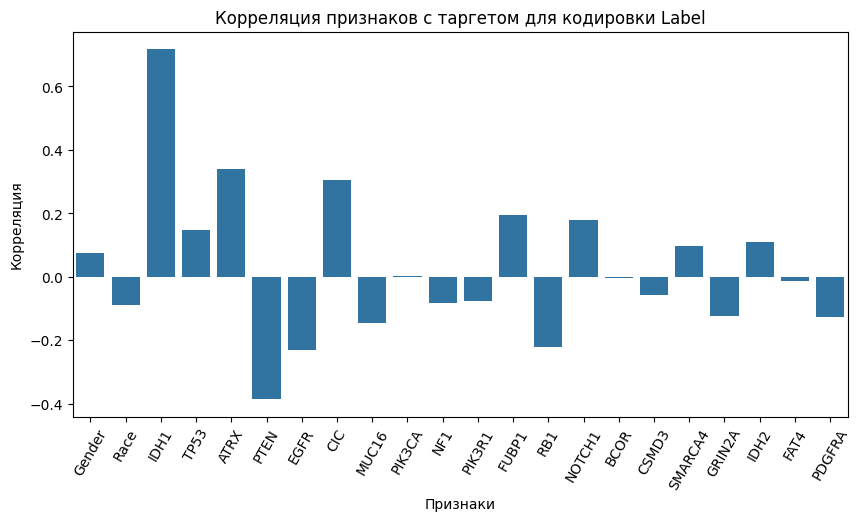

In [15]:
correlation_label =  label_train.corr()['Grade'].drop('Grade')
plt.figure(figsize=(10, 5))
sns.barplot(x=correlation_label.index, y=correlation_label.values)
plt.title('Корреляция признаков с таргетом для кодировки Label')
plt.xlabel('Признаки')
plt.ylabel('Корреляция')
plt.xticks(rotation = 60)
plt.show()

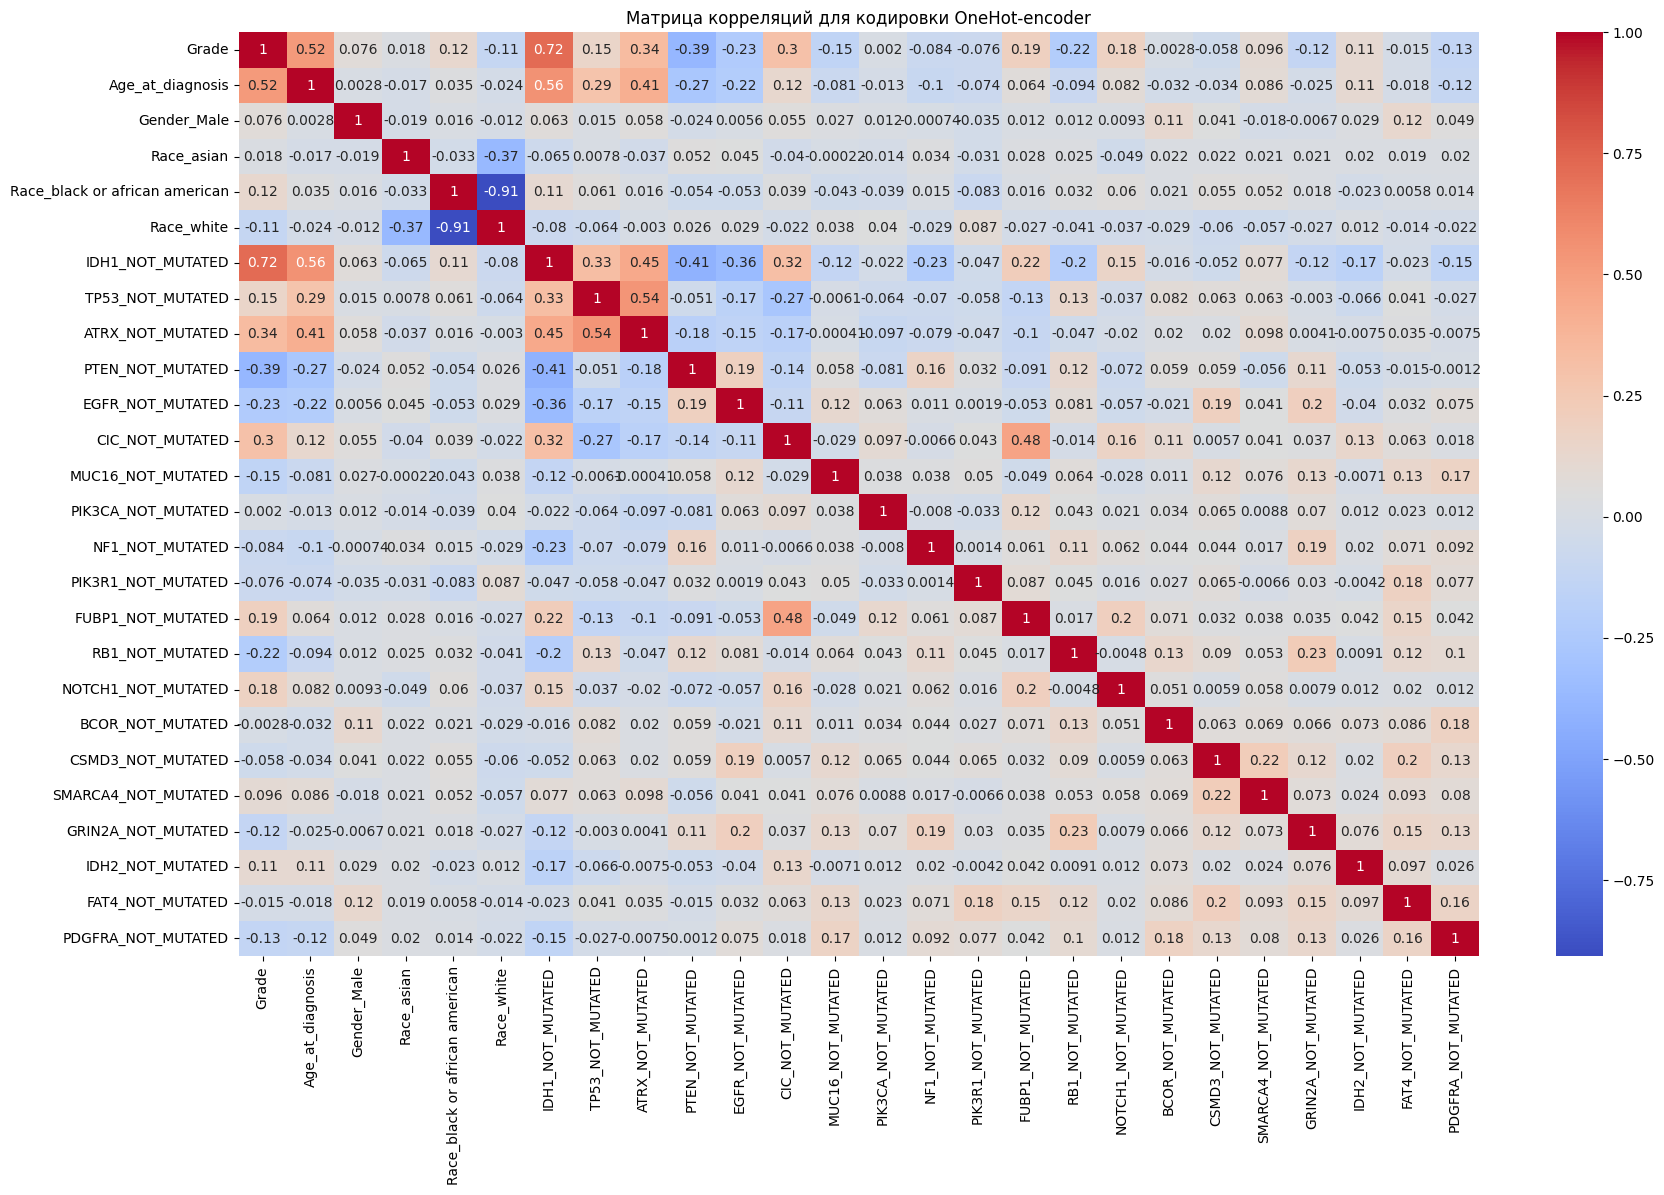

In [16]:
corr_matrix_ohe = train_ohe.corr()

plt.figure(figsize=(20, 12))
sns.heatmap(corr_matrix_ohe, annot=True, cmap='coolwarm')
plt.title('Матрица корреляций для кодировки OneHot-encoder')
plt.show()

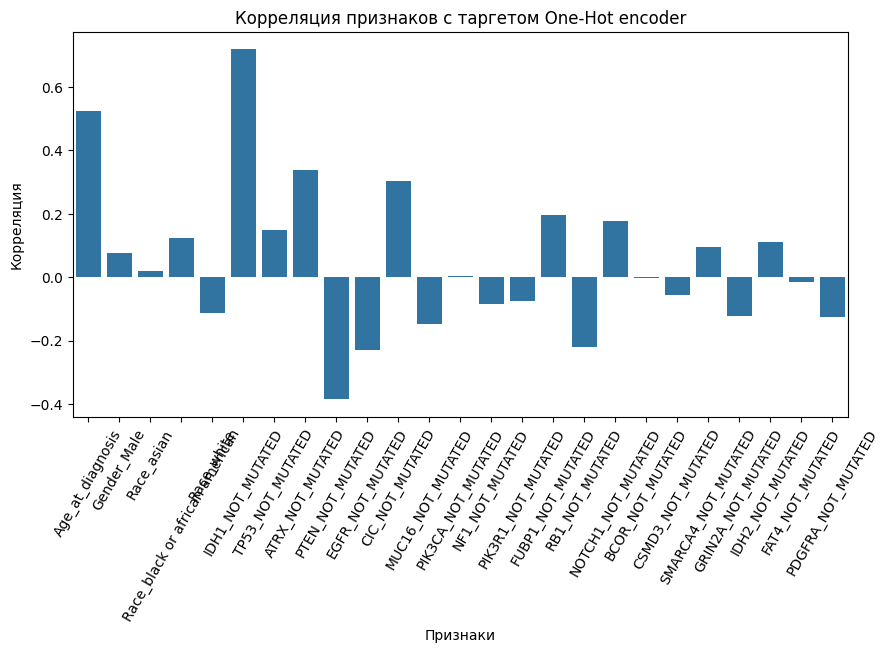

In [17]:
correlation_ohe =  train_ohe.corr()['Grade'].drop('Grade')
plt.figure(figsize=(10, 5))
sns.barplot(x=correlation_ohe.index, y=correlation_ohe.values)
plt.title('Корреляция признаков с таргетом One-Hot encoder')
plt.xlabel('Признаки')
plt.ylabel('Корреляция')
plt.xticks(rotation = 60)
plt.show()
#np.median(correlation1[abs(correlation1.values)>0.2])

**c. Perform feature selection**

Выбираем признаки с высокой корреляцией с зависимой переменной |corr|>0.2

In [18]:
selected_features = correlation_ohe[abs(correlation_ohe.values)>np.quantile(correlation_ohe, 0.8)].index
correlation_ohe[selected_features]

#np.quantile(correlation_ohe, 0.8)

,Grade
Age_at_diagnosis,0.522616
IDH1_NOT_MUTATED,0.717475
ATRX_NOT_MUTATED,0.338552
PTEN_NOT_MUTATED,-0.385557
EGFR_NOT_MUTATED,-0.230718
CIC_NOT_MUTATED,0.303952
FUBP1_NOT_MUTATED,0.193978
RB1_NOT_MUTATED,-0.221305


In [19]:
train_df = train_ohe[selected_features]
train_df['Grade'] = train['Grade']
test_df = test_ohe[selected_features]

<ipython-input-19-050dc66b56e1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Grade'] = train['Grade']


 Получем выборки:

*    train_df
*   test_df

В них данные закодированы, но **не** стандартизированы


In [20]:
# x_train_df содержит данные для обучения
x_train_df = train_df.copy()
x_train_df.drop(['Grade'], axis=1, inplace=True)
x_train_df.drop(['Age_at_diagnosis'], axis=1, inplace=True)
x_train_df = pd.concat([train_df['Age_at_diagnosis'].astype(int).copy(), x_train_df], axis=1)
x_train_df

,Age_at_diagnosis,IDH1_NOT_MUTATED,ATRX_NOT_MUTATED,PTEN_NOT_MUTATED,EGFR_NOT_MUTATED,CIC_NOT_MUTATED,FUBP1_NOT_MUTATED,RB1_NOT_MUTATED
0,79,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,53,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2,61,0.0,1.0,1.0,1.0,1.0,1.0,1.0
3,58,0.0,1.0,1.0,1.0,0.0,1.0,1.0
4,30,0.0,0.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...
598,67,1.0,1.0,1.0,1.0,1.0,1.0,1.0
599,27,0.0,0.0,1.0,1.0,1.0,1.0,1.0
600,29,0.0,0.0,1.0,1.0,1.0,1.0,1.0
601,51,0.0,1.0,1.0,1.0,1.0,1.0,1.0


In [21]:
# 5 задание:Try an ensemble model with trainable and non-trainable weights.

#Градиентный бустинг с обучаемыми весами

X_train, X_valid, y_train, y_valid = train_test_split(x_train_df, train_df['Grade'], test_size=0.2, random_state=42)

# Создание и обучение модели для теста оценки
gb_model = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, max_depth=3)
gb_model.fit(X_train, y_train)

# Оценка производительности
score = gb_model.score(X_valid, y_valid)
print(f"Accuracy: {score}")


Accuracy: 0.859504132231405


In [22]:
# Создание и обучение модели для прогнозирования
gb_model_main = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, max_depth=3)
gb_model_main.fit(x_train_df, train_df['Grade'])

# Прогнозируем на тестовых данных
predictions = gb_model_main.predict(test_df)

results_df = pd.DataFrame({
    'Id': range(len(predictions)),   # Если Id присутствует в тестовом DataFrame
    'Grade': predictions
})

# Сохранение результатов в файл
results_df.to_csv('predictions_gb.csv', index=False)

In [23]:
# Бэггинг с фиксированными весами (для теста точности)

X_train, X_valid, y_train, y_valid = train_test_split(x_train_df, train_df['Grade'], test_size=0.2, random_state=42)
X_train1, X_tmp, y_train1, y_tmp = train_test_split(X_train, y_train, test_size=0.66, random_state=42)
X_train2, X_train3, y_train2, y_train3 = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42)

# Обучение нескольких моделей - случайных лесов с разными параметрами или одно дерево
model_rf_1 = RandomForestClassifier(n_estimators=150, max_depth=7, random_state=42)
model_rf_2 = RandomForestClassifier(n_estimators=150, max_depth=5, random_state=42)
model_rf_3 = RandomForestClassifier(n_estimators=150, max_depth=7, random_state=42)

model_rf_1.fit(X_train1, y_train1)
model_rf_2.fit(X_train2, y_train2)
model_rf_3.fit(X_train3, y_train3)

# Получаем предсказания от моделей
preds_model1 = model_rf_1.predict(X_valid)
preds_model2 = model_rf_2.predict(X_valid)
preds_model3 = model_rf_3.predict(X_valid)

# Определяем фиксированные веса для предсказаний
weight1 = 0.5
weight2 = 0.3
weight3 = 0.2

# Комбинируем предсказания с фиксированными весами
final_preds = np.round(weight1 * preds_model1 + weight2 * preds_model2 + weight3 * preds_model3)

# Оценка производительности
accuracy = accuracy_score(y_valid, final_preds)
print(f"Accuracy: {accuracy}")


Accuracy: 0.859504132231405


In [24]:
# Бэггинг с фиксированными весами (для предсказания)

X_train1, X_tmp, y_train1, y_tmp = train_test_split(x_train_df, train_df['Grade'], test_size=0.66, random_state=42)
X_train2, X_train3, y_train2, y_train3 = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42)

# Обучение нескольких моделей - случайных лесов с разными параметрами или одно дерево
model_rf_1 = RandomForestClassifier(n_estimators=150, max_depth=7, random_state=42)
model_rf_2 = RandomForestClassifier(n_estimators=150, max_depth=5, random_state=42)
model_rf_3 = RandomForestClassifier(n_estimators=150, max_depth=7, random_state=42)

model_rf_1.fit(X_train1, y_train1)
model_rf_2.fit(X_train2, y_train2)
model_rf_3.fit(X_train3, y_train3)

# Получаем предсказания от моделей
preds_model1 = model_rf_1.predict(X_valid)
preds_model2 = model_rf_2.predict(X_valid)
preds_model3 = model_rf_3.predict(X_valid)

# Определяем фиксированные веса для предсказаний
weight1 = 0.5
weight2 = 0.3
weight3 = 0.2

# Комбинируем предсказания с фиксированными весами
final_preds = np.round(weight1 * preds_model1 + weight2 * preds_model2 + weight3 * preds_model3)

# Комбинируем предсказания с фиксированными весами
final_preds_test = np.round(weight1 * preds_model1 + weight2 * preds_model2 + weight3 * preds_model3)

results_df = pd.DataFrame({
    'Id': range(len(final_preds_test)),   # Если Id присутствует в тестовом DataFrame
    'Grade': final_preds_test.astype(int)
})


# Сохранение результатов в файл
results_df.to_csv('predictions_stacking.csv', index=False)

In [25]:
# Задание 6 - explainable model

model = LinearRegression()
model.fit(x_train_df, train_df["Grade"])

LinearRegression()

In [26]:
# Посмотрим на коэффициенты модели у каждого признака
print("Model coefs:\n")
for i in range(x_train_df.shape[1]):
    print(x_train_df.columns[i], "=", model.coef_[i].round(5))

Model coefs:

Age_at_diagnosis = 0.00561
IDH1_NOT_MUTATED = 0.51643
ATRX_NOT_MUTATED = 0.03959
PTEN_NOT_MUTATED = -0.13216
EGFR_NOT_MUTATED = 0.05712
CIC_NOT_MUTATED = 0.14957
FUBP1_NOT_MUTATED = 0.04053
RB1_NOT_MUTATED = -0.20704


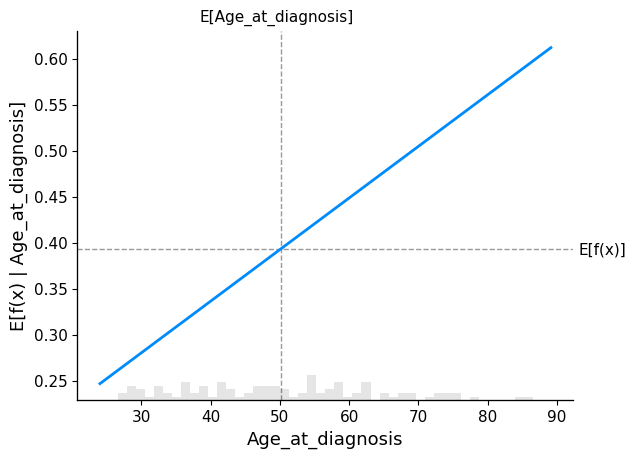

In [27]:
# Возьмём выборку из 100 образцов
x_100 = shap.utils.sample(x_train_df, 100)

# Посмотрим на график частичной зависимости предсказания модели от признака Age_at_diagnosis
shap.partial_dependence_plot(
    "Age_at_diagnosis",
    model.predict,
    x_100,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

ExactExplainer explainer: 604it [00:24, 24.94it/s]                         


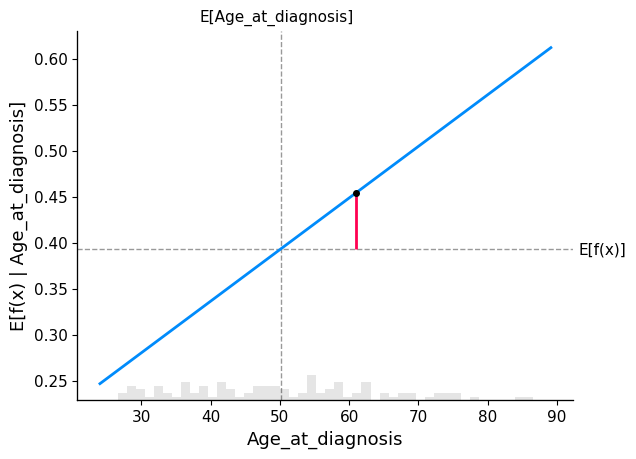

In [28]:
# Посчитаем SHAP values для линейной модели
explainer = shap.Explainer(model.predict, x_100)
shap_values = explainer(x_train_df)

# Построим график частичной зависимости и отобразим на нём SHAP values
sample_ind = 150
shap.partial_dependence_plot(
    "Age_at_diagnosis",
    model.predict,
    x_100,
    model_expected_value=True,
    feature_expected_value=True,
    ice=False,
    shap_values=shap_values[sample_ind : sample_ind + 1, :],
)

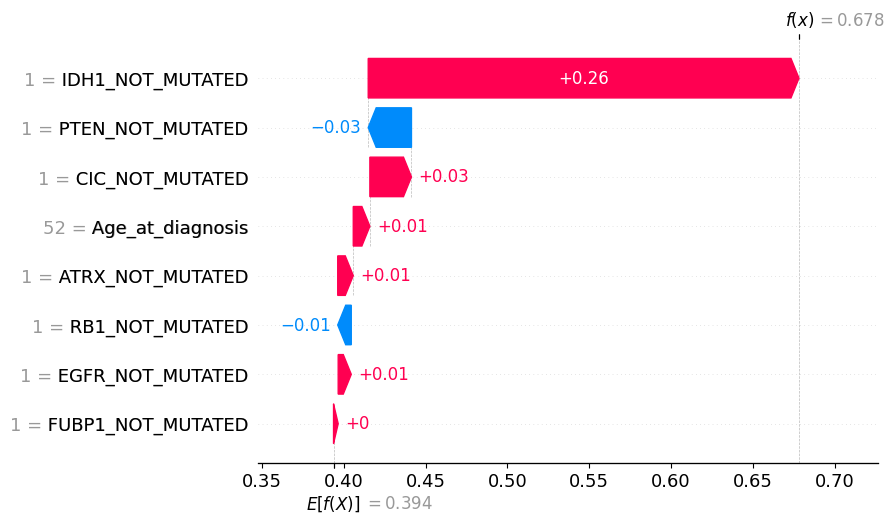

In [29]:
shap.plots.waterfall(shap_values[20], max_display=14)

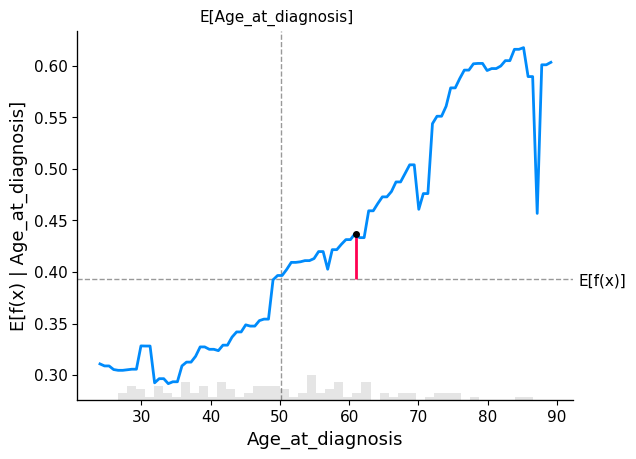

In [30]:
# Посмотрим ещё на обобщенную аддитивную модель
model_ebm = interpret.glassbox.ExplainableBoostingRegressor(interactions=0)
model_ebm.fit(x_train_df, train_df["Grade"])

explainer_ebm = shap.Explainer(model_ebm.predict, x_100)
shap_values_ebm = explainer_ebm(x_train_df)

fig, ax = shap.partial_dependence_plot(
    "Age_at_diagnosis",
    model_ebm.predict,
    x_100,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
    shap_values=shap_values_ebm[sample_ind : sample_ind + 1, :],
)

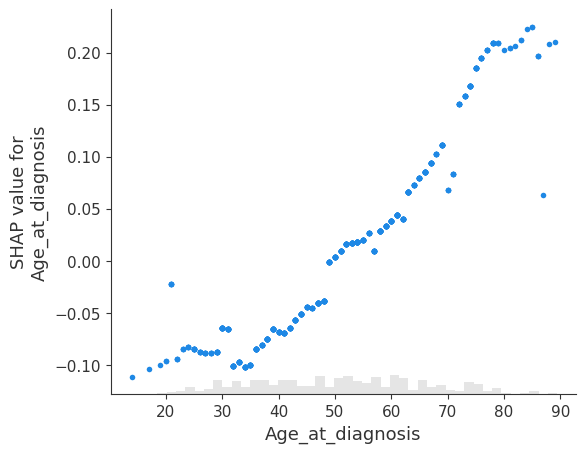

In [31]:
shap.plots.scatter(shap_values_ebm[:, "Age_at_diagnosis"])

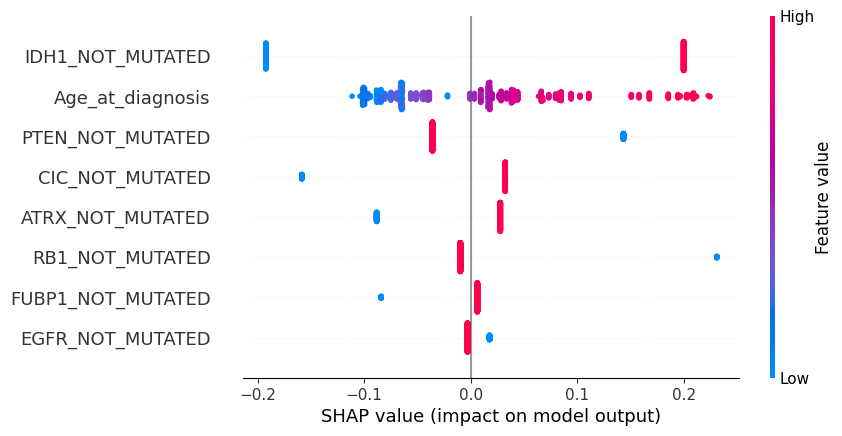

In [32]:
shap.plots.beeswarm(shap_values_ebm)

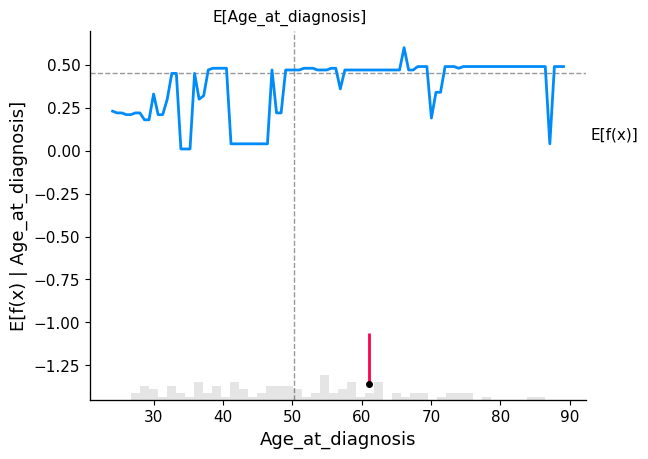

In [33]:
# И ещё посмотрим на нашу модель из пункта 5
explainer_gb = shap.Explainer(gb_model_main, x_100)
shap_values_gb = explainer_gb(x_train_df)

fig, ax = shap.partial_dependence_plot(
    "Age_at_diagnosis",
    gb_model_main.predict,
    x_100,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
    shap_values=shap_values_gb[sample_ind : sample_ind + 1, :],
)

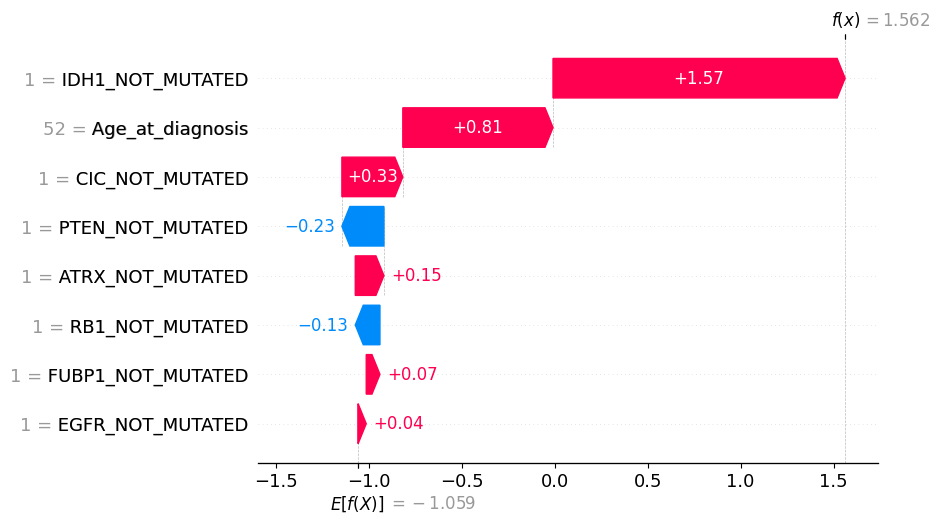

In [34]:
shap.plots.waterfall(shap_values_gb[20], max_display=14)

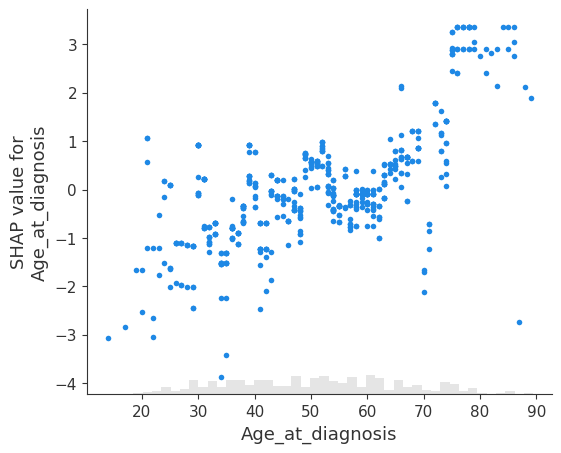

In [35]:
shap.plots.scatter(shap_values_gb[:, "Age_at_diagnosis"])